In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
torch.set_default_device('cpu')
torch.set_default_dtype(torch.float32)

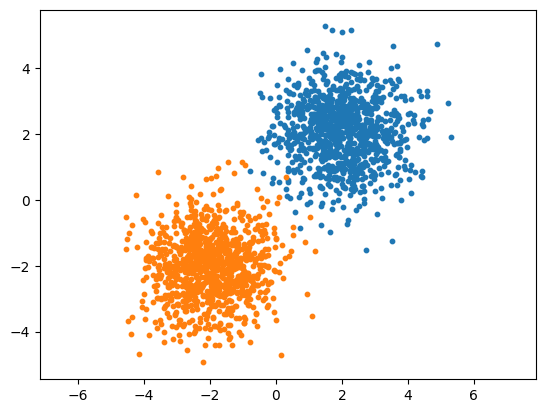

In [2]:
# generate data samples and scatter plot them
N_each_class=1000
N_data=N_each_class*2
data_dim=2
class1=torch.randn(N_each_class,data_dim)+2*torch.ones(N_each_class,data_dim)
class2=torch.randn(N_each_class,data_dim)-2*torch.ones(N_each_class,data_dim)
plt.scatter(np.array(class1[:,0].cpu()),np.array(class1[:,1].cpu()),s=10,alpha=1)
plt.scatter(np.array(class2[:,0].cpu()),np.array(class2[:,1].cpu()),s=10,alpha=1)
plt.axis("equal");

In [3]:
# define detector structure
net_width=50
class In_Out_Discirminator(torch.nn.Module):
    def __init__(self):
        super(In_Out_Discirminator, self).__init__()

        self.linear1 = torch.nn.Linear(data_dim, net_width)
        self.activation1 = torch.nn.ReLU()
        
        self.linear2 = torch.nn.Linear(net_width, net_width)
        self.activation2 = torch.nn.ReLU()

        self.linear3 = torch.nn.Linear(net_width, net_width)
        self.activation3 = torch.nn.ReLU()
        
        self.linear4 = torch.nn.Linear(net_width, net_width)
        self.activation4 = torch.nn.ReLU()
        
        self.linear5 = torch.nn.Linear(net_width, 1)
        self.activation5 = torch.nn.Sigmoid()
    
    def forward(self, x):
        x1 = self.linear1(x)
        x1 = self.activation1(x1)
        
        x2 = self.linear2(x1)
        x2 = self.activation2(x2)

        x3 = self.linear3(x2)
        x3 = self.activation3(x3)

        x4 = self.linear4(x3)
        x4 = self.activation4(x4+x2)

        x5 = self.linear5(x4)
        x5 = self.activation5(x5)
        return x5
        
D=In_Out_Discirminator()
opt_D= torch.optim.SGD(D.parameters(),lr=0.01, weight_decay=1e-6)

def loss_D_in(data):
    return torch.mean(-torch.log(D(data)+1e-10))
    
def loss_D_out(OOD):
    return torch.mean(-torch.log(-(D(OOD)-1)+1e-10))

In [4]:
# Step 1 train in-out discriminator
batchsize=50
epoch=10000
data=torch.cat((class1,class2),0)
for e in range(0,epoch):
    # sample in-domain data
    permutation=np.random.permutation(N_data)[0:batchsize]
    selected_ind_data=data[permutation,:]
    # sample trivial ood data from uniform distribution
    trivial_OOD=8*(torch.rand(batchsize,data_dim)-0.0)
    # losses
    L_in=loss_D_in(selected_ind_data)
    L_out=loss_D_out(trivial_OOD)
    # total loss
    Loss=10*L_in+L_out
    # update parameters
    # zero grad
    opt_D.zero_grad()
    # backward
    Loss.backward()
    # upgrad
    opt_D.step()
    # print losses
    if (e%1000==0):
        print(round(L_in.item(),4),end="-")
        print(round(L_out.item(),4),end="  ")

0.7304-0.5891  0.0247-1.06  0.0521-0.4651  0.0354-0.8343  0.032-0.9696  0.0389-1.1415  0.0176-1.0742  0.0487-1.0203  0.0273-0.5623  0.0163-0.8287  

In [5]:
# log normed derivative: log|dD(x)/dx|
def get_1_grad(input):
    input_num=torch.Tensor.size(input)[0]
    J=torch.reshape(torch.autograd.functional.jacobian(D,input,create_graph=True),(1*input_num,data_dim*input_num))
    return 0.5*torch.log(torch.sum(torch.pow(J,2),1)+1e-10)
# derivative of the log normed derivative: dlog|dD(x)/dx|/dx
def get_2_grad(input):
    input_num=torch.Tensor.size(input)[0]
    J=torch.autograd.functional.jacobian(get_1_grad,input)
    return torch.reshape(torch.sum(torch.reshape(J,(1*input_num,data_dim*input_num)),0),(input_num,data_dim))

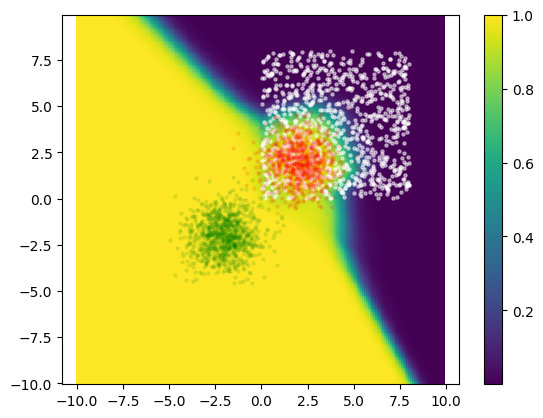

In [6]:
# visualise the initial state:
# get grid in [-10,10]2
R=10
xs=torch.arange(-R,R,0.1)
ys=torch.arange(-R,R,0.1)
test_inputs=[]
for i in range(0,len(xs)):
    for j in range(0,len(ys)):
        temp=torch.zeros(data_dim)
        temp[0]=xs[i]
        temp[1]=ys[j]
        test_inputs.append(temp)
inputs=torch.stack(test_inputs)
outputs=D(inputs).detach()

trivial_OOD=8*(torch.rand(1000,data_dim)-0.0)
plt.pcolormesh(xs,ys,torch.reshape(outputs,(len(xs),len(ys))).numpy())
plt.colorbar()
plt.scatter(np.array(trivial_OOD[:,1]),np.array(trivial_OOD[:,0]),s=5,alpha=0.5,color="white")
plt.scatter(np.array(class1[:,1]),np.array(class1[:,0]),s=5,alpha=0.1,color="red")
plt.scatter(np.array(class2[:,1]),np.array(class2[:,0]),s=5,alpha=0.1,color="green")
plt.axis("equal");

In [ ]:
# optimization starts
Round=100  # total rounds
l_LMC=10000 # length of LMC
N_chain=5  # number of LMC chains
X_boundary=torch.zeros(l_LMC,N_chain,data_dim) # tensor to store extracted samples
# start
for Rd in range(0,Round):
    print("Round:",Rd)
    # select starting points from in-domain data
    x_b=torch.zeros(N_chain,data_dim)
    permutation=np.random.permutation(N_data)[0:N_chain]
    x_b=data[permutation,:]
    # set hyperparameters
    ϵ=0.001 # LMC stepsize
    T=1.0 # temperature T<=1.0
    # run Langevin Dynamics
    for e in range(0,l_LMC):
        # print
        if (e%1000==0):
            print(e,end="-")
            print(get_1_grad(x_b[0,:].reshape(-1,1).t()).detach(),end="-")
            print((D(x_b[0,:].reshape(-1,1).t())).detach()[0])
        # update x_b
        # calculate update
        update = ϵ*get_2_grad(x_b)+torch.sqrt(2*ϵ*torch.ones(1))*torch.randn(N_chain,data_dim)*T
        # propose new states
        propose = x_b + update
        # Metropolis-Hastings step
        u = torch.rand(N_chain)
        α = torch.exp((get_1_grad(propose).detach()-get_1_grad(x_b).detach())/T)
        if_accept = u<α
        p = torch.Tensor.repeat(if_accept.reshape(-1,1),(1,data_dim))
        # update states and record
        x_b = x_b + p*update
        X_boundary[e,:,:] = x_b[:,:]
    
    full_len=len(X_boundary)
    half_len=int(full_len/2)
    # memory mechanism
    if Rd==0:
        X_boundary_second_half=X_boundary[half_len:full_len,:,:]
        s=X_boundary_second_half.size()
        X_boundary_data=X_boundary_second_half.reshape((s[0]*s[1]),2)# create buffer
    else:
        X_boundary_second_half=X_boundary[half_len:full_len,:,:]
        s=X_boundary_second_half.size()
        X_boundary_data=torch.cat((X_boundary_second_half.reshape((s[0]*s[1]),2),\
                                   X_boundary_data),0) # update buffer
    
    # train D on in-domain data, trivial OOD and extracted samples to upgrad the boundary
    epoch=3000 # update for 3000 epochs
    for e in range(0,epoch):
        # sample in-domain data
        permutation=np.random.permutation(N_data)[0:batchsize]
        selected_ind_data=data[permutation,:]
        # sample trivial ood data from uniform distribution
        trivial_OOD=8*(torch.rand(batchsize,data_dim)-0.0)
        # sample from extracted samples
        permutation=np.random.permutation(len(X_boundary_data))[0:batchsize]
        boundary_OOD=X_boundary_data[permutation,:]
        # losses
        L_in=loss_D_in(selected_ind_data)
        L_out=loss_D_out(trivial_OOD)
        L_b=loss_D_out(boundary_OOD)
        # total loss
        Loss=L_in+0.1*L_out+0.01*L_b
        # update parameters
        # zero grad
        opt_D.zero_grad()
        Loss.backward()
        # upgrad
        opt_D.step()
        # print loses
        if (e%1000==0):
            print(round(L_in.item(),4),end="-")
            print(round(L_out.item(),4),end="-")
            print(round(L_b.item(),4))
    
    # randomly retain 50% of the whole buffer
    perm=np.random.permutation(len(X_boundary_data))[0:int(len(X_boundary_data)*0.5)]
    retained_part=X_boundary_data[perm,:]
    X_boundary_data=retained_part
    #--------------------------------------------------------------------
    
    # visualisation and save figures
    R=10
    xs=torch.arange(-R,R,0.1)
    ys=torch.arange(-R,R,0.1)
    test_inputs=[]
    for i in range(0,len(xs)):
        for j in range(0,len(ys)):
            temp=torch.zeros(data_dim)
            temp[0]=xs[i]
            temp[1]=ys[j]
            test_inputs.append(temp)
    inputs=torch.stack(test_inputs)
    outputs=D(inputs).detach()
    plt.clf()
    plt.pcolormesh(xs,ys,torch.reshape(outputs,(len(xs),len(ys))).numpy())
    plt.colorbar()
    plt.scatter(np.array(class1[:,1]),np.array(class1[:,0]),s=5,alpha=0.1,color="red")
    plt.scatter(np.array(class2[:,1]),np.array(class2[:,0]),s=5,alpha=0.1,color="green")
    plt.scatter(np.array(trivial_OOD[:,1]),np.array(trivial_OOD[:,0]),s=5,alpha=0.5,color="white")

    permutation=np.random.permutation(len(X_boundary_data))[0:300]
    sampled_OOD=X_boundary_data[permutation,:]
    plt.scatter(np.array(sampled_OOD[:,1]),np.array(sampled_OOD[:,0]),s=5,alpha=0.5,color="black")
  
    plt.axis("equal");
    plt.axis([-R, R, -R, R])
    plt.savefig("f"+str(Rd)+".png")

Round: 0
0-tensor([-10.7585])-tensor([1.0000])
1000-tensor([-1.5265])-tensor([0.9269])
2000-tensor([-2.8569])-tensor([0.9372])
3000-tensor([-1.3611])-tensor([0.8827])
4000-tensor([-2.0347])-tensor([0.9483])
5000-tensor([-2.1685])-tensor([0.9307])
6000-tensor([-3.1925])-tensor([0.9504])
7000-tensor([-1.7286])-tensor([0.8809])
8000-tensor([-0.7781])-tensor([0.8210])
9000-tensor([-0.0400])-tensor([0.4949])
0.0348-0.937-1.2798
0.0171-0.5987-0.6755
0.0577-0.7114-0.379
Round: 1
0-tensor([-2.4700])-tensor([0.9432])
1000-tensor([-1.0403])-tensor([0.7847])
2000-tensor([-0.6776])-tensor([0.7636])
3000-tensor([-0.7959])-tensor([0.7866])
4000-tensor([-0.1748])-tensor([0.4196])
5000-tensor([-0.3175])-tensor([0.5087])
6000-tensor([-0.6169])-tensor([0.7320])
7000-tensor([-0.4212])-tensor([0.6537])
8000-tensor([-0.1293])-tensor([0.5547])
9000-tensor([-0.1929])-tensor([0.3959])
0.0616-0.9729-0.7984
0.0323-0.7267-0.3234
0.023-1.0608-0.6293
Round: 2
0-tensor([-11.5129])-tensor([1.])
1000-tensor([-11.5129